# HW6: Multidimensional Distributions and Copulas

## Preliminaries

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy.linalg as linalg
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.special as special



### Random Seed

In [2]:
seed=7839
gen=np.random.default_rng(seed)

### Code

#### Back-Scholes Calculator

In [3]:
epsilon=1e-12

def bs_price_fwd(isCall, K, T, F, sigma):
    """ Black's pricing formula
    
    European option  forward price as a function of
    the asset's forward.
    
    :param isCall: True for calls , False for Puts
    :type isCall: Boolean
    :param K: option strike
    :param T: option expiry in years
    :param F: forward of the options underlying asset
    :param sigma: underlying's  volatility
    :return: option's forward price
    """
    ds=np.maximum(0.000001,sigma*np.sqrt(T))
    dsig=0.5*ds*ds
    d2=(np.log(F/np.maximum(K,epsilon))-dsig)/ds
    d1=d2+ds
    if isCall:
        opt= F*special.ndtr(d1) - K*special.ndtr(d2)
    else:
        opt= K*special.ndtr(-d2) - F*special.ndtr(-d1)
    return opt

#### Implied Volatility Calculator
<a id="bs_implied_fwd"></a>

In [4]:
class BSPriceTarget: # this class could be replaced by a lambda function
    def __init__(self,isCall,K,T,F,p):
        self.isCall=isCall
        self.K=K
        self.T=T
        self.F=F
        self.p=p
    def __call__(self,sigma):
        #print(sigma,bs_price_fwd(self.isCall,self.K,self.T,self.F,sigma))
        return  bs_price_fwd(self.isCall,self.K,self.T,self.F,sigma)-self.p
def bs_implied_fwd(isCall, K, T, F, p, tol=1e-8,max_iter=1000, max_sigma=4):
    """ Implied Blacks scholes volatility.
    
    European option implied volatility as a function of  forward option price and
    underlying forward.
    
    :param isCall: True for calls , False for Puts
    :type isCall: Boolean
    :param K: option strike
    :param T: option expiry in years
    :param F: forward of the options underlying asset
    :parm p: forward option price to expiry.
    :param sigma: initial guess of the underlying's  volatility
    :param tol: tolerance, the implied volatility returned by this function when used in :meth:`bs_price_fwd` function will match *p* with at most *tol* error.
    :aram max_sigma: maximum level of volatility to attempt, defaults to 200%
    :return: option's implied volatility
    """
    func=BSPriceTarget(isCall,K,T,F,p)
    sol=optimize.root_scalar(func,bracket=[0.0,max_sigma],x0=0.2,xtol=tol,maxiter=max_iter)
    return sol.root

<a id="mc_implied_vols"> </a>
#### Implied Vol with Uncertainty


In [5]:
def mc_implied_vols(is_calls,Ks,T,F,price,dprice,z_std=2):
    if isinstance(is_calls,bool): # if only one input, promote to array
        is_calls=[is_calls]*len(Ks)
    ivols=[]
    ivols_low=[]
    ivols_high=[]
    for idx,K in enumerate(Ks):
        p=price[idx]
        dp=dprice[idx]
        is_call=is_calls[idx]
        ivol=0
        try:
            ivol=bs_implied_fwd(is_call,K,T,F,p)
        except:
            pass
        ivol_l=0
        try:
            ivol_l=bs_implied_fwd(is_call,K,T,F,p-z_std*dp)
        except:
            pass
        ivol_h=0
        try:
            ivol_h=bs_implied_fwd(is_call,K,T,F,p+z_std*dp)
        except:
            pass
        ivols.append(ivol)
        ivols_low.append(ivol_l)
        ivols_high.append(ivol_h)
    ivols=np.array(ivols)
    ivols_low=np.array(ivols_low)
    ivols_high=np.array(ivols_high)
    return ivols,ivols_low,ivols_high

#### SVI Volatility Curve

In [6]:
class SVICurve:
    def __init__(self,T,F,vol_ATM,b,rho,m,sigma):
        self.T=T
        self.F=F
        self.a=vol_ATM**2*T-b*(-rho*m+np.sqrt(m**2+sigma**2)) 
        self.b=b
        self.rho=rho
        self.m=m
        self.sigma=sigma        
    def __call__(self,K):
        k=np.log(K/self.F)
        var=self.a + self.b*(self.rho*(k-self.m)+np.sqrt((k-self.m)**2+self.sigma**2))
        return np.sqrt(var/self.T)

#### Risk Neutral Distribution

In [7]:
class RiskNeutral:
    def __init__(self,T,F,vol):
        self.T=T
        self.F=F
        self.vol=vol
    def cdf(self,K,dk=0.001):
        dK=K*dk
        K0=K-dK
        sig0=self.vol(K0)
        p0=bs_price_fwd(False,K0,self.T,self.F,sig0)
        K1=K+dK
        sig1=self.vol(K1)
        p1=bs_price_fwd(False,K1,self.T,self.F,sig1)
        return  (p1-p0)/dK/2.0
    def pdf(self,K,dk=0.001):
        dK=K*dk
        return (self.cdf(K)-self.cdf(K-dK))/dK       
    def ppf(self,u,tol=1e-4,max_iter=21): # inverse cdf
        T=self.T
        F=self.F
        sigma=self.vol(F)
        var=sigma**2*T
        std=np.sqrt(var)
        S=np.empty_like(u.ravel())
        
        S0=F*np.exp(-15*std)
        cdf0=self.cdf(S0)
        pdf0=self.pdf(S0)
        u1=u.ravel() #linearize into one long vector
        idx=u1.argsort() # we will visit them in increasing order
        for i1 in range(len(idx)):
            U=u1[idx[i1]]
            # solve equation  
            #    cdf(S)=u
            # using brent's method
            iter=0
            while np.abs(cdf0-U)/cdf0>tol:
                S1=S0+(U-cdf0)/pdf0
                cdf1=self.cdf(S1)
                pdf0=(cdf1-cdf0)/(S1-S0)
                cdf0=cdf1
                S0=S1
                iter+=1
                if (iter>=max_iter):
                    break
            S[idx[i1]]=S0
                    
        return S.reshape(u.shape)
    def rvs(self,gen,size,tol=1e-4,max_iter=21):
        u=gen.uniform(size=size)
        return self.ppf(u,tol,max_iter)

#### Multivariate Log Normal Distribution
<a id="generate_multivariate_lognormal"> </a>

In [8]:
def generate_multivariate_lognormal(T,F,sigma,rho,N,gen):
    L=linalg.cholesky(rho)
    D=len(F) # number of variables
    var=sigma**2*T  # vector of variances
    mu=np.log(F)-0.5*var 
    z=gen.normal(size=(N,D))
    w=np.dot(z,L.T)
    x=mu+np.sqrt(var)*w # correlated normal 
    return np.exp(x)   # correlated log-norma

### Gaussian Copula

In [9]:
class GaussianCopula:
    def __init__(self,rho):
        self.rho=rho
    def generate(self,N,gen):
        D=len(self.rho)
        Z=stats.multivariate_normal(np.zeros(D),self.rho,seed=gen,allow_singular=True).rvs(size=N)
        U=stats.norm.cdf(Z)
        return U

<a id="generate_distribution"> </a>
#### Generate Distribution from Copula

In [10]:
def generate_distribution(dists,copula,N,gen):
    U=copula.generate(N,gen) # correlated U(0,1)
    Ss=[]
    for i1,dist in enumerate(dists):
        S=dist.ppf(U[:,i1]) # inverse cdf
        Ss.append(S)
    return np.stack(Ss,axis=-1)

## Problem 1: Basket Options

A basket on $D$ assets is defined as 
$$
    B = \frac{1}{D}\sum_{d=1}^D \frac{S_d}{S_{0,d}}
$$
where $S_{d}$ is the price level of asset $d$ at option expiry and $S_{0,d}$ is a fixed **reference level**
that is chosen at the initiation of the trade. 

A basket option has payout:
$$
    \text{payout}=\max( \eta (B-K),0)
$$
where 
$$
    \eta =\begin{cases}
                1 \ \ \text{if call} \\
                -1 \ \ \text{if put} 
            \end{cases}
$$

### Problem 1.1

Implement the `basket_option_payout` function below where 
1. `S` is an $N\times D$ matrix of samples from the expiry distribution of asset prices
2. `S0` is a $D$ vector of reference levels.
3. `is_call` is a boolean indicating if the payoff is a call or a put.
4. `K` is the option strike.

In [11]:
def basket_option_payout(S,S0,is_call,K):
    pass

In [12]:
def basket_option_payout(S,S0,is_call,K):
    B=np.mean(S/S0,axis=-1)
    eta=2*is_call-1
    return np.maximum(eta*(B-K),0)

### Problem 1.2: 

We will price options on $D=5$  log-normal asset with 
1. Expiry $T=1$.Exception
2. Forward $F_d=1 (all assets have the same forward)
3. At the Money volatility $\sigma_\text{ATM}=20\%$
4. A strike $K-1$.
5. Reference levels $S_0=1$ for all assets
6. A correlation $\rho=70\%$ for all asset pairs.

Generate $N=10,000$ samples of the join distribution of the $D=5$ assets using function [`generate_multivariate_lognormal`](#generate_multivariate_lognormal)

[HINT] You will need to generate a $D\times D$ correlation matrix with ones in the diagonal and $\rho=70\%$ in the off-diagonal terms 

In [13]:
D=5
T=1
F=1
sigma_ATM=0.2
K=1




In [14]:

Fs=F*np.ones(D)
S0=F*np.ones(D)
sigmas=sigma_ATM*np.ones(D)

In [15]:
rho=0.7
corr=(1-rho)*np.identity(D)+rho*np.ones((D,D))
corr

array([[1. , 0.7, 0.7, 0.7, 0.7],
       [0.7, 1. , 0.7, 0.7, 0.7],
       [0.7, 0.7, 1. , 0.7, 0.7],
       [0.7, 0.7, 0.7, 1. , 0.7],
       [0.7, 0.7, 0.7, 0.7, 1. ]])

In [16]:
N=10_000
S=generate_multivariate_lognormal(T,Fs,sigmas,corr,N,gen)
S.shape

(10000, 5)

### Problem 1.3:

Make a scatter plot of the join distributions of the first to assets in the basket

Text(0, 0.5, '$S_2$')

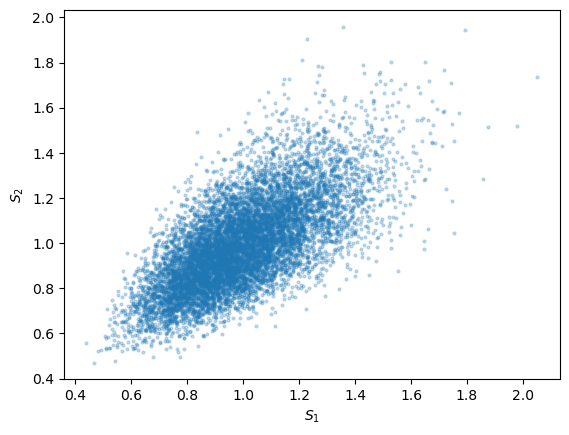

In [17]:
plt.scatter(S[:,0],S[:,1],alpha=0.25,s=4,edgecolors=None)
plt.xlabel("$S_1$")
plt.ylabel("$S_2$")

### Problem 1.4

Compute the estimated basket forward and its uncertainty
$$
    F_B = \mathbb{E}[ B ]= \mathbb{E}\left[\frac{1}{D}\sum_{d=1}^D \frac{S_d}{S_{0,d}}\right]
$$
using the Monte Carlo samples

In [18]:
F_B=np.mean(S/S0)
F_B,np.std(S/S0)/np.sqrt(N)

(0.9948223222677501, 0.0019931451665478107)

### Problem 1.5

Using the $N=10,000$ samples generated in Problem 1.3 price a basket call  option with strike $K=1$, compute the Monte Carlo uncertainty of the estimated price.

In [19]:
pay=basket_option_payout(S,S0,True,K)
pay.shape


(10000,)

In [20]:
price=pay.mean()
dprice=pay.std()/np.sqrt(N)
price,dprice

(0.06648989552891689, 0.0010742526964996597)

### Problem 1.6:

Compute the implied volatility of the basket price using the function [`bs_implied_fwd`](#bs_implied_fwd).

Is the implied volatility of the basket higher or lower than the single asset volatility $\sigma_\text{ATM}$? 

[HINT] As forward in the call to `bs_implied_fwd` use the basket forward $F_B$ estimated in Problem 1.4

In [21]:
# it is a bit lower than the single asset volatility sigma_ATM=0.2
ivol=bs_implied_fwd(True,K,T,F_B,price)
ivol

0.17374518129032993

### Problem 1.7

Compute a 95\% probability interval for the implied volatilities by computing implied volatilities two standard deviations above and below the Monte Carlo price.

In [22]:
ivol_l=bs_implied_fwd(True,K,T,F_B,price-2*dprice)
ivol_h=bs_implied_fwd(True,K,T,F_B,price+2*dprice)
ivol_l,ivol,ivol_h

(0.16832340142250274, 0.17374518129032993, 0.17916808705535542)

### Problem 1.8

1. Compute the call and put option prices and their uncertainties for a uniform grid of strikes in the range $K\in[0.75,1.25]$. 
2. Make a plot of price vs strike for calls and puts. Make sure to indicate the uncertainty of the prices in the graph.

[HINT] You must create four arrays `price_call`, `price_put` for the price of calls and puts, and `dprice_call`, `dprice_put` for
the Monte Carlo uncertainties of those prices.

In [23]:
Ks=np.linspace(0.75,1.25,101)

In [24]:
price_call=np.empty(len(Ks))
dprice_call=np.empty(len(Ks))
price_put=np.empty(len(Ks))
dprice_put=np.empty(len(Ks))
for i1,K in enumerate(Ks):
    pay_call=basket_option_payout(S,S0,True,K)
    price_call[i1]=pay_call.mean()
    dprice_call[i1]=pay_call.std()/np.sqrt(N)
    pay_put=basket_option_payout(S,S0,False,K)
    price_put[i1]=pay_put.mean()
    dprice_put[i1]=pay_put.std()/np.sqrt(N)

Text(0, 0.5, 'Option Price')

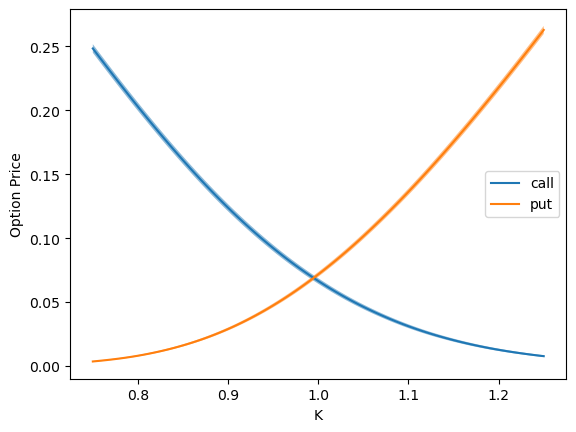

In [25]:
plt.plot(Ks,price_call,label="call")
plt.fill_between(Ks,price_call-2*dprice_call,price_call+2*dprice_call,alpha=0.5)

plt.plot(Ks,price_put,label="put")
plt.fill_between(Ks,price_put-2*dprice_put,price_put+2*dprice_put,alpha=0.5)
plt.legend()
plt.xlabel("K")
plt.ylabel("Option Price")

### Problem 1.9

1. Using function ['mc_implied_vols'](#mc_implied_vols) compute the implied volatilites of the put and calls for each strike and their $\pm 2$ standard deviation confident intervals
2. Make a plot of implied volatility  vs strike for calls and puts. Make sure to indicate the uncertainty of the volatilities in the graph. 

In [26]:
ivol_call,ivol_call_l,ivol_call_h=mc_implied_vols(True,Ks,T,F_B,price_call,dprice_call,z_std=2)
ivol_put,ivol_put_l,ivol_put_h=mc_implied_vols(False,Ks,T,F_B,price_put,dprice_put,z_std=2)

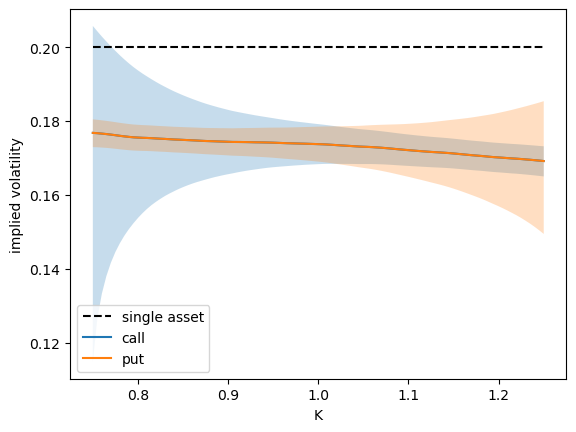

In [27]:
plt.plot(Ks,sigma_ATM*np.ones(len(Ks)),"k--",label="single asset")
plt.plot(Ks,ivol_call,label="call")
plt.fill_between(Ks,ivol_call_l,ivol_call_h,alpha=0.25)
plt.plot(Ks,ivol_put,label="put")
plt.fill_between(Ks,ivol_put_l,ivol_put_h,alpha=0.25)
plt.xlabel("K")
plt.ylabel("implied volatility")
plt.legend()

### Problem 1.10

A good approximation for the basket implied volatility $\sigma_B$ is
$$
    \sigma_B^2 = \frac{1}{D}\sum_{d,d'=1}^N \rho_{d,d'} \sigma_d \sigma_{d'}
$$

where $\sigma_d$ is the volatility of asset $d$ (in our example $\sigma_d=\sigma_\text{ATM}=20\%$)

1. Compute the basket volatility $\sigma_B$.
2. Repeat the graph of problem 1.9 but including now a horizontal line for the basket volatility $\sigma_B$

In [28]:
sig=sigma_ATM*np.identity(D)
cov=np.dot(sig,np.dot(corr,sig))
sigma_B=np.sqrt(np.mean(cov))
sigma_B

0.17435595774162693

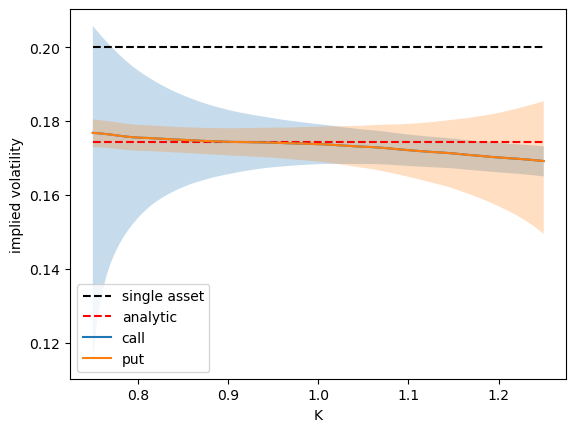

In [29]:
plt.plot(Ks,sigma_ATM*np.ones(len(Ks)),"k--",label="single asset")
plt.plot(Ks,sigma_B*np.ones(len(Ks)),"r--",label="analytic")
plt.plot(Ks,ivol_call,label="call")
plt.fill_between(Ks,ivol_call_l,ivol_call_h,alpha=0.25)
plt.plot(Ks,ivol_put,label="put")
plt.fill_between(Ks,ivol_put_l,ivol_put_h,alpha=0.25)
plt.xlabel("K")
plt.ylabel("implied volatility")
plt.legend()

## Problem 2: Risk Neutral Valuation

We will now price basket options using a risk neutral volatility surface derived from market data and a **Gaussian copula**.


For convenience we will have $D=5$ **identical asset** each one of them defined with the following
parameters:
 

1. Expiry $T=1$
2. Forward $F=1$
3. ATM volatility is 20\%
4. The other parameters of the SVI parametrization are given by:
    1. $b=.13$
    2. $\rho=-0.734$
    3. $m=.128$
    4. $\tilde{\sigma}$=0.118

### Problem 2.1

1. define the SVI volatility curve.
2. define the Risk Neutral Distribution for one asset
3. Create an array with 5 identical copies of  the risk neutral distribution.

In [30]:
T=1
F=1
sigma_ATM=0.2
b=0.13
rho=-0.734
m=0.128
sigma=0.118

In [31]:
vol=SVICurve(T,F,sigma_ATM,b,rho,m,sigma)
dist=RiskNeutral(T,F,vol)

In [32]:
dists=[dist]*D

### Problem 2.2: 

We will price options on $D=5$ assets with
1.  the risk neutral distribution we defined in Problem 2.1
6. A correlation $\rho=70\%$ for all asset pairs.

Generate $N=10,000$ samples of the join distribution of the $D=5$ assets using function [`generate_distribution`](#generate_distribution) and a Gaussian copula

[HINT] You will need to generate a $D\times D$ correlation matrix with ones in the diagonal and $\rho=70\%$ in the off-diagonal terms 

In [33]:
copula=GaussianCopula(corr)

In [34]:
N=10_000
S=generate_distribution(dists,copula,N,gen)
S.shape
 

(10000, 5)

### Problem 2.3:

Make a scatter plot of the join distributions of the first to assets in the basket


Text(0, 0.5, '$S_2$')

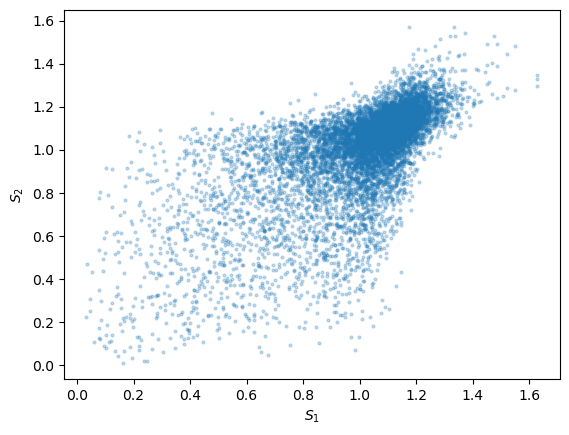

In [35]:
plt.scatter(S[:,0],S[:,1],alpha=0.25,s=4,edgecolors=None)
plt.xlabel("$S_1$")
plt.ylabel("$S_2$")

### Problem 2.4

Use the Kolmogorov-Smirnov test to verify that the distribution of the first two assets matched the expected risk neutral distribution

In [36]:
stats.kstest(S[:,0],dist.cdf)

KstestResult(statistic=0.007758956518878146, pvalue=0.5810524194370639)

In [37]:
stats.kstest(S[:,1],dist.cdf)

KstestResult(statistic=0.008996714082050938, pvalue=0.3908914583564008)

### Problem 2.5

Compute the estimated basket forward and its uncertainty
$$
    F_B = \mathbb{E}[ B ]= \mathbb{E}\left[\frac{1}{D}\sum_{d=1}^D \frac{S_d}{S_{0,d}}\right]
$$
using the Monte Carlo samples

In [38]:
F_B=np.mean(S/S0)
F_B

1.0003499525863973

### Problem 2.6

1. Compute the call and put option prices and their uncertainties for a uniform grid of strikes in the range $K\in[0.75,1.25]$. 
2. Make a plot of price vs strike for calls and puts. Make sure to indicate the uncertainty of the prices in the graph.

[HINT] You must create four arrays `price_call`, `price_put` for the price of calls and puts, and `dprice_call`, `dprice_put` for
the Monte Carlo uncertainties of those prices.

In [39]:
price_call=np.empty(len(Ks))
dprice_call=np.empty(len(Ks))
price_put=np.empty(len(Ks))
dprice_put=np.empty(len(Ks))
for i1,K in enumerate(Ks):
    pay_call=basket_option_payout(S,S0,True,K)
    price_call[i1]=pay_call.mean()
    dprice_call[i1]=pay_call.std()/np.sqrt(N)
    pay_put=basket_option_payout(S,S0,False,K)
    price_put[i1]=pay_put.mean()
    dprice_put[i1]=pay_put.std()/np.sqrt(N)

Text(0, 0.5, 'Option Price')

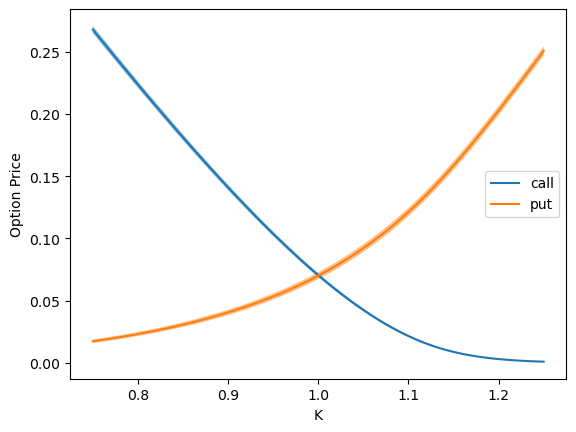

In [40]:
plt.plot(Ks,price_call,label="call")
plt.fill_between(Ks,price_call-2*dprice_call,price_call+2*dprice_call,alpha=0.5)

plt.plot(Ks,price_put,label="put")
plt.fill_between(Ks,price_put-2*dprice_put,price_put+2*dprice_put,alpha=0.5)
plt.legend()
plt.xlabel("K")
plt.ylabel("Option Price")

### Problem 2.7

1. Using function ['mc_implied_vols'](#mc_implied_vols) compute the implied volatilities of the put and calls for each strike and their $\pm 2$ standard deviation confident intervals
2. Make a plot of implied volatility  vs strike for calls and puts. Make sure to indicate the uncertainty of the volatilities in the graph. 

In [41]:
ivol_call,ivol_call_l,ivol_call_h=mc_implied_vols(True,Ks,T,F_B,price_call,dprice_call,z_std=2)
ivol_put,ivol_put_l,ivol_put_h=mc_implied_vols(False,Ks,T,F_B,price_put,dprice_put,z_std=2)

Text(0, 0.5, 'implied volatility')

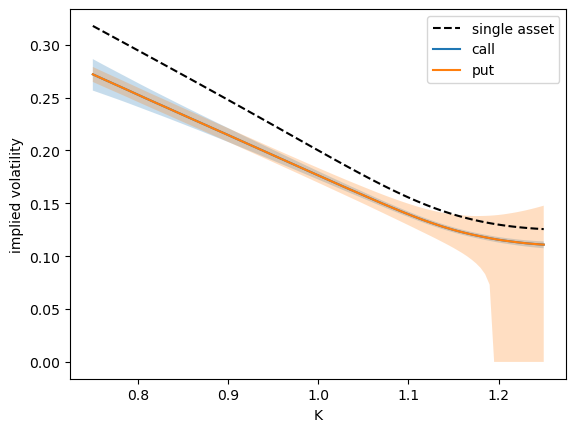

In [42]:
plt.plot(Ks,vol(Ks),"k--",label="single asset")
plt.plot(Ks,ivol_call,label="call")
plt.fill_between(Ks,ivol_call_l,ivol_call_h,alpha=0.25)
plt.plot(Ks,ivol_put,label="put")
plt.fill_between(Ks,ivol_put_l,ivol_put_h,alpha=0.25)
plt.legend()
plt.xlabel("K")
plt.ylabel("implied volatility")

### Problem 2.8

A good approximation for the basket implied volatility $\sigma_B$ at strike $K$ is:
$$
    \sigma_B(K)^2 = \frac{1}{D}\sum_{d,d'=1}^N \rho_{d,d'} \sigma_d(K) \sigma_{d'}(K)
$$

where $\sigma_d(K)$ is the SVI volatility of asset $d$ at strike $K$.

1. Compute the basket volatility $\sigma_B$ for all the strikes you used in Problem 2.6.
2. Repeat the graph of problem 2.7 but now add superimpose a plot of $\sigma_B(K)$

In [43]:
sigma_B=np.empty(len(Ks))
for i1,K in enumerate(Ks):
    sig=vol(K)*np.identity(D)
    cov=np.dot(sig,np.dot(corr,sig))
    sigma_B[i1]=np.sqrt(np.mean(cov))


Text(0, 0.5, 'implied volatility')

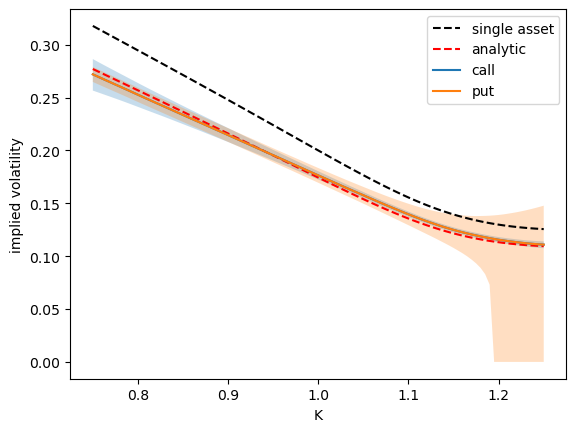

In [44]:
plt.plot(Ks,vol(Ks),"k--",label="single asset")
plt.plot(Ks,sigma_B,"r--",label="analytic")
plt.plot(Ks,ivol_call,label="call")
plt.fill_between(Ks,ivol_call_l,ivol_call_h,alpha=0.25)
plt.plot(Ks,ivol_put,label="put")
plt.fill_between(Ks,ivol_put_l,ivol_put_h,alpha=0.25)
plt.legend()
plt.xlabel("K")
plt.ylabel("implied volatility")